# Estimating the mass of exoplanets

When a star has planetary companions, it describes an epicyclic motion around the center of mass of the system. When the motion has a component in the direction of the observer (the direction of the line of sight), this allows to detect the planetary companions. Indeed, as the distance between an observer and a star changes, because of the Doppler effect, the light received by the observer shifts in frequency.

By measuring spectra at different times and measuring how the spectral absorption lines shift in wavelength, it is possible to obtain the star velocity in the direction of the line of sight. We then have a time series of measurements, with a nominal error on each of them. If one detects a periodic signal in the time series, then this one might be due to a planet. 

Determining if a periodic signal is present and if it originates from a planet is difficult, and will not be the object of the present exercise. In this spreadsheet, we assume that a planet has been detected, and we want to determine its orbital elements, especially its mass. 

To simplify the problem, we assume that the planet has a circular orbit (that is a zero eccentricity). 

The first part of this homework is the forward model: given the physical parameters and the instrument, what is the likelihood function of the data ? 

We then compute the maximum likelihood estimates of the parameters when the period is known.

Finally, we compute the posterior distribution of the parameters, and interval estimates of the mass. This part requires to code a Metropolis-Hastings algorithm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import emcee
import corner

## I. The forward model
----
----

Let us suppose that a planet of mass $m$ orbits a star of mass $M$ at a semi-major axis $a$ and eccentricity 0. We want to express the velocity of the $\mathbf{star}$ in the direction observer - barycenter (the radial velocity). 

To facilitate the calculation of the radial velocity, we define two inertial frame: the observing frame $(x,y,z)$ and the orbital frame $(x',y',z')$. Both frames have their origin $O$ at the barycenter of the system { star + planet }. The observing frame $z$ axis is oriented in the direction observer - star. The plane perpendicular to $z$ is called the sky plane. 

The orbital frame $z'$ axis is perpendicular to the plane of the orbit and its direction is such that the $\mathbf{planet}$ orbits is in the trigonometric (or counterclocwise) sense. 
The $x$ and $x'$ axes are pointing at the ascending node, that is the point where the orbit crosses the sky plane from negative $z$ coordinates to positive $z$ coordinates. 
The $y$ and $y'$ axes are such that $(x,y,z)$ and $(x',y',z')$ are direct orthonormal bases. The semi-major axis of  the planet is denoted by $a$.  

The angle $(z,z')$ is denoted by $i$. 

------------ 
-----

I.1) Show that the position of the $\mathbf{star}$ in the orbital frame at time $t$ is 
$$ r(t) = -a \frac{m}{M+m} \left[ \cos(\nu (t - t_0)),  \sin(\nu (t - t_0)), 0 \right ] $$ 
where $t_0$ is the time of passage at the ascending node and $$\nu = \sqrt{\frac{G(m+M)}{a^3}}$$.


<font color='blue'>

We assume that the planet and the star are point masses. From classical orbital mechanics it is known that two point masses in gravitational interaction have a planar motion. We here assume that their orbit is circular. In the orbital frame, the motion of the point mass with mass $M$ (the star) is 
$$ r_\star(t) = a \frac{m}{M+m} \left[ \cos(\nu t +\phi_s ),  \sin(\nu t +\phi_s), 0 \right ] $$
where $\phi$ is the phase of the orbit at $t=0$ and $a$ is the distant between the two point masses. The position of the planet is 
$$ r_p(t) = a \frac{M}{M+m} \left[ \cos(\nu t +\phi_p ),  \sin(\nu t +\phi_p), 0 \right ] $$
where $\phi_p  = \phi_s + \pi$.

When the planet is at its ascending node, its phase is 0, so $\nu t_0+\phi_p = 0$ so $\phi_p = - \nu t_0$  and $\phi_s
= - \nu t_0 + \pi$. Therefore, the position of the $\mathbf{star}$ in the orbital frame at time $t$ is 
$$ r_\star(t) = -a \frac{m}{M+m} \left[ \cos(\nu (t - t_0)),  \sin(\nu (t - t_0)), 0 \right ] $$.

By Kepler's second law,
$$\nu = \sqrt{\frac{G(m+M)}{a^3}}$$

I.2) Show that the velocity of the $\mathbf{star}$ projected onto the $z$ axis at time $t$ is  $$ V(t) = V_0 +  \frac{ G^\frac{1}{3}\nu^\frac{1}{3} }{(m+M)^\frac{2}{3}} m \sin i \cos(\nu (t - t_0))  $$ where $V_0$ is the velocity of the barycenter with respect to the observer.



<font color='blue'>
Let us express the position of the star in the reference frame $(x,y,z)$. Denoting by $M$ the matrix of coordinate change 
 $$ M =  \left(
\begin{matrix}
1 & 0 & 0 \\
0 & \cos i & -\sin i \\
0 & \sin i& \cos i 
\end{matrix}
\right)
 $$

 The position of the star in the  reference frame $(x,y,z)$, $q(t)$,  is then $q(t) = Mr(t)$. The $z$ component of $q$ is 
 $$ 
 z = \sin i  \left(- a \frac{m}{M+m}\right)   \sin(\nu (t -t_0) ) 
 $$
 Therefore 
$$ 
 \frac{\mathrm{d} z}{\mathrm{d} t} =  - a \sin i   \frac{m}{M+m}  \nu   \cos(\nu (t -t_0) ) 
 $$
 by expressing $a$ as a function of $\nu$ with Kepler's second law, we obtain the desired formula.


I.3) We assume that we have $N$ radial velocity measurements at time $(t_k)_{k=1..N}$.  with an instrument that has nominal error bar $\sigma_k$ for the measurement $k$. In principle, one could assume a the following form for the probability of the data knowing the parameters (the likelihood), 
$$ p(y|m, M, i, \nu,t_0, V_0)  = \frac{1}{ \sqrt{2\pi}^N\prod\limits_{k=1}^N \sigma_k} \mathrm{e}^{-\frac{1}{2} \sum\limits_{k=1}^N \frac{ \left(y(t_k) - V_0 -  \frac{ \nu^\frac{1}{3} G^\frac{1}{3} }{(m+M)^\frac{2}{3}} m \sin i \cos(\nu (t - t_0)) \right)^2 }{\sigma_k^2} }.$$ 

However, in the rest of this spreadsheet we will assume the likelihood is 
$$p(y|A,B,C, \nu) = \frac{1}{ \sqrt{2\pi}^N\prod\limits_{k=1}^N \sigma_k} \mathrm{e}^{-\frac{1}{2} \sum\limits_{k=1}^N \frac{(y(t_k) - A \cos \nu t_k - B \sin \nu t_k - C)^2}{\sigma_k^2} } \;\;\;\;\;\;\;\;\; (1)$$

Give the advantage of the chosen formulation, with parmeters $A,B,C$ over the formulation with parameters $m, M, i, \nu,v_0$ and express $A,B,C$ as a function $m, M, i, t_0,\nu,V_0$.


<font color='blue'>

Let $\frac{mv^{1/3}G^{1/3}}{(m+M)^{2/3}} = K$, then,

\begin{equation}
V_0 + K\cdot \sin{i}\cos({\nu(t-t_0)}) = A\cos{\nu t_k} + B\sin{\nu t_k} +C
\end{equation}

That means $C=V_0$, and

\begin{equation}
    K\sin{i}\cos({\nu t - \nu t_0}) = A\cos{\nu t_k} + B\sin{\nu t_k} \\
    \Rightarrow K\sin{i} (\cos{\nu t}\cos{\nu t_0} + \sin{\nu t}\sin{\nu t_0}) = A\cos{\nu t_k} + B\sin{\nu t_k}\\
    \Rightarrow K\sin{i}\cos{\nu t_0} \cos{\nu t} + K\sin{i}\sin{\nu t_0}\sin{\nu t} = A\cos{\nu t_k} + B\sin{\nu t_k}
\end{equation}

Comparing the coefficients of the last equations,

\begin{equation}
    \begin{split}
        A &= K\sin{i}\cos{\nu t_0} \\
        \Rightarrow A &= m\frac{v^{1/3}G^{1/3}}{(m+M)^{2/3}}\sin{i}\cos{\nu t_0}
    \end{split}
\end{equation}

(Note: Thus, we can find $m$ using $A$,

$$m = \frac{AM^{2/3}}{\nu^{1/3} G^{1/3} \sin{i} \cos{\nu t_0}}$$

which can be useful in later derivation.)

and,

\begin{equation}
    \begin{split}
        B &= K\sin{i}\sin{\nu t_0} \\
        \Rightarrow B &= m\frac{v^{1/3}G^{1/3}}{(m+M)^{2/3}}\sin{i}\sin{\nu t_0}
    \end{split}
\end{equation}

## II. Point estimates

---
---

In this part of the homework, we assume that we have radial velocity data $y = (y(t_i))_{i=1..N}$. 
We model $y$ as a sum of a sinusoidal model due to the planet and a Gaussian noise of mean zero and variance $\sigma_i^2$ for the measurement at time $t_i$.
$$y(t_i) = A\cos \nu t_i + B\sin \nu t_i + C + \epsilon_i$$
where $$\epsilon_i \sim G(0, \sigma_i^2)$$

We assume that the uncertainties $(\sigma_i)_{i=1..N}$ are known. 

-----
-----

II.1) Justify that the likelihood of the model is given by equation (1).

<font color='blue'>
    
The $\epsilon_i$ are Gaussian and independent, therefore their covariance matrix is diagonal with $i$-th element $\sigma_i^2$. Knowing the parameters $\theta$, when the noise is white (i.e. uncorrelated), for a model $f(\theta)$, a Gaussian likelihood has the form
$$p(y | \theta ) =  \frac{1}{ \sqrt{2\pi}^N\prod\limits_{k=1}^N \sigma_k} \mathrm{e}^{-\frac{1}{2} \sum\limits_{k=1}^N \frac{(y(t_k) - f(\theta))^2}{\sigma_k^2} } \;\;\;\;\;\;\;\;\; (1)$$

Here, $f(\theta) =A\cos \nu t_i + B\sin \nu t_i + C $. By replacing in the equation above we get the expression of equation 1.

II.2) We first assume that the frequency $\nu$ is known. Show that the maximum likelihood estimate of $\theta = (A,B,C)$ is of the form $$\hat{\theta} = (M^T V^{-1} M)^{-1} M^T V^{-1} y$$
where the suffix $T$ denotes the matrix transposition, $V$ is a diagonal matrix whose elements are $V_{ii} = \sigma_i^2$ and $M$ is a $N \times 3$ matrix.

Write the explicit expression $M$ as a function of $\nu$. 

<font color='blue'>

Since the model is assumed to have the Gaussian noise and the model is linear model, one can write the estomator as $\hat{\theta} = (M^T V^{-1} M)^{-1} M^T V^{-1} y$ as derived in the class. The expression for $M$ can be written as,

\begin{pmatrix}
\cos{\nu t_1} & \sin{\nu t_1} & 1\\
\cos{\nu t_2} & \sin{\nu t_2} & 1\\
. & . & . \\
\cos{\nu t_n} & \sin{\nu t_n} & 1\\
\end{pmatrix}

II.3) Bonus question: show that if $\phi$ is a function and $\hat(\theta)$ is the maximum likelihood estimate of $\theta$, then the maximum likelihood estimate of $\phi(\theta)$ is $\phi(\hat{\theta})$.

This result can be used in the following question even if it is not proved.

<font color='blue'>
    
We first define the maximum likelihood estimate of $\phi(\theta)$. 
     
Let us first suppose that $\phi$ is a bijection, in that case we define $p'(y|\phi(\theta)) = p(y|\theta)$, then, if the inferior bound of $\{  p(y|\theta), \theta \in \Theta \}$ is attained, $arg \max_{\theta } p(y|\theta)$ exists. Since $p'(y|\phi(\theta)) = p(y|\theta)$, denoting by 
$$ \theta_{ML} = arg \max_{\phi(\theta) } p(y|\theta) $$, 
$$ arg \max_{\phi(\theta) }p'(y|\phi(\theta)) = p(y|\phi(\theta_{ML})) $$

If $\phi$ is not a bijection, then we can comsider $\tilde{\phi}: \Theta \rightarrow \phi(\Theta) \times \Theta$
where $\tilde{\phi}(\theta) = (\phi(\theta), \theta)$, which is a bijection. Then we define
$$ p''(y|\tilde{\phi}(\theta) )= p(y|\theta) $$ and the reasoning above applies to $p''$ instead of $p'$.

II.4) For $m = 4$  $M_\oplus$, $M = 0.65$ $M_\odot$, $i = 90°$, $\nu = \frac{2*\pi}{6.5}$ radian/day, $t_0 = 0$, $V_0 = 0$, 
generate the expected radial velocity signal $y_0(t)$ at the times of the column 'time' in the file homework_rv.txt.

Note: $M_\oplus$ and $M_\odot$ designate the Earth mass and the Solar mass

Text(0, 0.5, 'Radial Velocity signal (in m/s)')

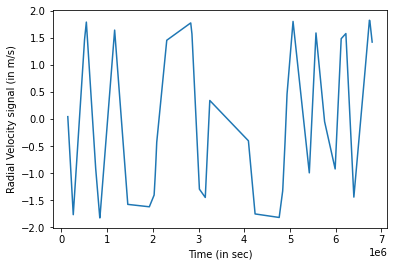

In [2]:
mp = 4*5.972e+24
Ms = 0.65*1.989e+30
incli = np.pi/2
nu = (2*np.pi)/(6.5*24*60*60)
t0 = 0
V0 = 0
G = 6.6743e-11
K = (mp* nu**(1/3) * G**(1/3))/((mp+Ms)**(2/3))
A = K*np.sin(incli)*np.cos(nu*t0)
B = K*np.sin(incli)*np.sin(nu*t0)
C = V0
time1, rv, rve = np.loadtxt('homework_rv.txt', usecols=(0,1,2), unpack=True)
time = time1*24*60*60
y0 = A*np.cos(nu*time) + B*np.sin(nu*time) + C
plt.plot(time, y0)
plt.xlabel('Time (in sec)')
plt.ylabel('Radial Velocity signal (in m/s)')

II. 5) Using the column 'errors' of the file homework_rv.txt., generate 100,000 realizations of a Gaussian noise plus $y_0$, compute the empirical variance and bias of $\hat{m}$. Plot the empirical distribution of $\hat{m}$ and compute its empirical bias and variance.

In [3]:
def mass(Aa, Bb):
    global incli, Ms, nu, G
    KK = np.sqrt(Aa**2 + Bb**2)
    KK1 = KK/np.sin(incli)
    mm = KK1*Ms**(2/3)/(nu**(1/3) * G**(1/3))
    return mm

Empirical Measurements:
-----------------------
Estimate: 4.004185500352841 M_earth
Bias: 0.004185500352840599 M_earth
Variance: 0.023882261095976756 M_earth^2
Standard Deviation: 0.15453886597221023 M_earth


Text(0, 0.5, 'Counts')

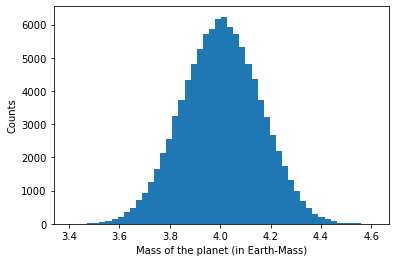

In [4]:
nsim = 100000
V = np.diag(rve)
V1 = np.linalg.inv(V)

M11 = np.vstack((np.cos(nu*time), np.sin(nu*time)))
M = np.vstack((M11, np.ones(len(time)))).T
MT = M.T

F1 = MT.dot(V1).dot(M)
F2 = np.linalg.inv(F1)

AA = np.array([])
BB = np.array([])
CC = np.array([])
theta = np.array([])

for i in range(nsim):
    y2 = y0 + np.random.random(len(y0))
    F3 = MT.dot(V1).dot(y2)
    theta1 = F2.dot(F3)
    theta = np.hstack((theta, theta1))
    AA = np.hstack((AA, theta1[0]))
    BB = np.hstack((BB, theta1[1]))
    CC = np.hstack((CC, theta1[2]))
    
m_estimate = mass(AA, BB)
m_pesti = m_estimate/5.972e+24
bias1 = np.mean(m_pesti)-4
vari = np.var(m_pesti)
stdd = np.std(m_pesti)
print('Empirical Measurements:')
print('-----------------------')
print('Estimate: ' + str(np.mean(m_pesti)) + ' M_earth')
print('Bias: ' + str(bias1) + ' M_earth')
print('Variance: ' + str(vari) + ' M_earth^2')
print('Standard Deviation: ' + str(stdd) + ' M_earth')
#print(np.mean(m_pesti), np.std(m_pesti))
plt.hist(m_pesti, bins=50)
plt.xlabel('Mass of the planet (in Earth-Mass)')
plt.ylabel('Counts')

## The Metropolis-Hastings algorithm

---
---
A common way to derive uncertainties on the parameter is to compute their posterior distributions $p(\theta|y)$. 
In the following, we assume that $\theta$ belongs to an open subset of $\mathbb{R}^p$ and $\theta$ has a prior density ditribution $p(\theta)$. The density of the posterior distribution of the parameters is then 
$$ p(\theta|y) =  \frac{p(y|\theta) p(\theta)}{p(y)}   $$
where, according to the total probability formula 
$$p(y) = \int\limits_{\theta \in \Theta}  p(y|\theta) p(\theta) \mathrm{d}\theta $$

In general, $p(\theta|y)$ does not have an analytical expression. To approximate it, paradoxically enough, it might be simpler to generate samples $(\theta_i)_{i=1}^N$ from $p(\theta|y) $ and approximate the true distribution $ p(\theta|y)$ from the empirical distribution of the $(\theta_i)_{i=1}^N$.

The most common way to generate a sequence $(\theta_i)_{i=1}^N$ following the distribution $p(\theta|y)$ is to use a Metropolis-Hastings algorithm, whose principle is as follows.

We define a transition probability, called the proposal distribution, that is a function $q: \theta \in  \Theta \times \theta' \in  \Theta \rightarrow q_\theta(\theta')$ such that for each $\theta \in \Theta$, $\theta' \in  \Theta \rightarrow q_\theta(\theta')$ is a probability density. 
Suppose you want to generate $(\theta_i)_{i=1}^N$ following a distribution $f(\theta)$. Assuming the state at iteration $i$ is $\theta_i$.

1. Generate $\theta' \sim q_{\theta_i}(\theta')$
2. Compute $$\alpha = \min \left\{ 1, \frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') }   \right\} (2) $$
3. Generate $u$ with a uniform distribution between 0 and 1. If $u \geqslant \alpha$, assign $\theta_{i+1} \leftarrow \theta'$. It is said that the proposal is accepted. Else $\theta_{i+1} \leftarrow \theta_{i}$, the proposal is said to be rejected. 
4. Repeat for $i \leftarrow i+1$

The fraction of iterations where the proposal is accepted is called the acceptance rate. The series of $\theta_i$ obtaines is called the "chain". 

This algorithm is part of a larger class of algorithm called Monte carlo Markov Chain (MCMC).

Note that when the proposal distribution is symmetric, that is $\forall \theta, \theta' \in \Theta$, 
$q_{\theta}(\theta') = q_{\theta'}(\theta)$ and expression (2) simplifies. 

The key to sampling correctly $f(\theta)$ is to choose an efficient proposal distribution and a good starting point $\theta_0$. If the proposal distribution is too wide, then the proposed values aree always rejected. If it is too narrow, then the states of the chain $\theta_i$ are too correlated with each other, and the exploration of the parameter space is too slow. A good rule of thumb is to aim at an acceptance ratee of 23%.

Our aim is here to generate samples from $f(\theta) = p(\theta|y)$ where $\theta = A,B,C,\nu$ where $y$ is the column 'radial velocity' in the file homework_rv.txt

---
---


III.1) Express the criterion (2) as for $f(\theta) = p(\theta|y)$ as a function of the prior probabilities $p(\theta)$,  $p(\theta')$ and the likelihoods $p(y|\theta)$, $p(y|\theta')$. What is the crucial advantage of the Metropolis-Hastings algorithm for the generation of samples from a posterior distribution, over a generation of samples with the inverse CDF?


<font color='blue'>

From the Bayes theorem,

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

Which is nothing but $f(\theta)$. Similarly, for $f(\theta') = \frac{p(y|\theta')p(\theta')}{p(y)}$. Their ratio (which is what needed in the algorithm) can be thus given as,

$$ \frac{f(\theta')}{f(\theta)} = \frac{p(y|\theta')p(\theta')}{p(y|\theta)p(\theta)}$$

Here $p(\theta')$ and $p(\theta)$ are the prior probabilities; $p(y|\theta')$ and $p(y|\theta)$ are the likelihood functions.

III.2) For numerical stability, the fraction $\frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') }$ is not computed directly, we compute its logarithm. Express the criterion 2 as a function of the logarithms of the prior probabilities $p(\theta)$,  $p(\theta')$, the likelihoods $p(y|\theta)$, $p(y|\theta')$ and the logarithms of $q_{\theta'}(\theta_i)$, $q_{\theta_i}(\theta')$.

<font color='blue'>

First of all we want to write the fraction $\frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') }$ in the form of prior probabilities and likelihood functions.

$$\frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') } = \frac{p(y|\theta')p(\theta') q_{\theta'}(\theta_i)}{p(y|\theta)p(\theta)q_{\theta_i}(\theta')}$$

We now can take logarithm on the both side of above equation,

\begin{equation}
    \begin{split}
        \log \left[\frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') }\right] &= \log{p(y|\theta')} + \log{p(\theta')} + \log{q_{\theta'}(\theta_i)} - \log{p(y|\theta)} - \log{p(\theta)} - \log{q_{\theta_i}(\theta')}
    \end{split}
\end{equation}

Now, the criterion 2 says,

$$\alpha = \min \left\{ 1, \frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') } \right\} $$

Taking logarithm on both sides of above equation,

\begin{equation}
    \begin{split}
        \log{\alpha} &= \min \left\{ \log{1}, \log \left[\frac{f(\theta') q_{\theta'}(\theta_i)}{f(\theta_i) q_{\theta_i}(\theta') }\right] \right\} \\
        \Rightarrow \log{\alpha} &= \min \left\{ 0, \log{ \frac{p(y|\theta')p(\theta') q_{\theta'}(\theta_i)}{p(y|\theta)p(\theta)q_{\theta_i}(\theta')}} \right\}\\
        \Rightarrow \log{\alpha} &= \min \left\{ 0, \log{p(y|\theta')} + \log{p(\theta')} + \log{q_{\theta'}(\theta_i)} - \log{p(y|\theta)} - \log{p(\theta)} - \log{q_{\theta_i}(\theta')} \right\}
    \end{split}
\end{equation}

III.3) We assume that the prior distributions on $A,B,C, \nu$ is

$$p(A,B,C,\nu) = p(A)p(B)p(C)p(\nu) $$

where $A, B$ and $C$ $\sim G(0,\sigma^2) $ with sigma = 100 m/s and $\nu$ has a uniform distribution. 


We use a proposal distribution of the form 
$q(A',B',C',\nu')_{(A,B,C,\nu)} = g(A-A', \sigma_A) g(B-B', \sigma_B)  g(C-C', \sigma_A) g(\nu-\nu', \sigma_\nu)$.
where $g(x, \sigma) = \frac{1}{\sqrt{2\pi} \sigma} \mathrm{e}^{-\frac{x^2}{2\sigma^2}}$

In this expression, $\sigma_A$, $\sigma_B$, $\sigma_C$ and $\sigma_\nu$ are to be tuned to find an efficient proposal distribution. 

Using question III.2), write a Metropolis-Hastings code starting at  $\nu_0 = 2\pi/6.5$ and $A_0, B_0, C_0$ given by the least square solution (see question II.2) where the acceptance rate is between 5 and 35 % (that is, find suitable $\sigma_A$, $\sigma_B$, $\sigma_C$ and $\sigma_\nu$ to obtain this property) and perform 2,000,000 iterations.


Indication: for $\sigma_\nu$ take a fraction of $2\pi/T_{\mathrm{obs}}$ where $T_{\mathrm{obs}}$ is the total timespan of observations (the difference between the last and first observation dates).

<font color='blue'>

First we want to make the eqaution for $\log \alpha$ a little simple by noting the fact that the given proposal distribution is symmetric (a gaussian distribution). Thus $q_{\theta}(\theta') = q_{\theta'}(\theta)$ and so the equation for $\log \alpha$ would become,

$$\log{\alpha} = \min \left\{ 0, \log{p(y|\theta')} + \log{p(\theta')} - \log{p(y|\theta)} - \log{p(\theta)} \right \}$$

Now, we know that,

$$p(y|\theta) = \frac{1}{ \sqrt{2\pi}^N\prod\limits_{k=1}^N \sigma_k} \mathrm{e}^{-\frac{1}{2} \sum\limits_{k=1}^N \frac{(y(t_k) - f(\theta))^2}{\sigma_k^2} }$$

where, $f(\theta) = A \cos \nu t_k - B \sin \nu t_k - C$. Using this equation, one can find log likelihood as follows,

\begin{equation}
    \begin{split}
        \log p(y|\theta) &= -\frac{N}{2} \log 2\pi - \sum\limits_{k=1}^{N} \log \sigma_k - \frac{1}{2} \sum\limits_{k=1}^{N} \frac{(y_k - f(\theta))^2}{\sigma_k ^2} \\
     \end{split}
\end{equation}

Here, again $f(\theta) = A \cos \nu t_k - B \sin \nu t_k - C$ and $f(\theta') = A' \cos \nu t_k - B' \sin \nu t_k - C'$.

Similarly, we can do the same for the prior probabilities, which have the following distribution,

$$p(\theta) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\left(-\frac{\theta^2}{2\sigma^2}\right)}$$

We also know that,

$$p(A,B,C,\nu) = p(A)p(B)p(C)p(\nu)$$

with $p(A)$, $p(B)$ and $p(C)$ having a gaussian distribution and $p(\nu)$ having the uniform distribution. Using this information, we can write above equation as,

$$p(\theta) = p(A,B,C,\nu) = \frac{1}{\sqrt{2\pi}\sigma_A} e^{-\frac{A^2}{2\sigma_A^2}} \frac{1}{\sqrt{2\pi}\sigma_B} e^{-\frac{B^2}{2\sigma_B^2}} \cdot \frac{1}{\sqrt{2\pi}\sigma_C} e^{-\frac{C^2}{2\sigma_C^2}} \cdot \nu$$

$$\Rightarrow p(\theta) = \frac{1}{\sqrt{2\pi}^3\sigma_A \sigma_B \sigma_C} e^{-\frac{A^2}{2\sigma_A^2}-\frac{B^2}{2\sigma_B^2}-\frac{C^2}{2\sigma_C^2}} \cdot \nu $$
    
$$\Rightarrow \log{p(\theta)} = -\frac{3}{2}\log{2\pi} -\log{\sigma_A} - \log{\sigma_B} - \log{\sigma_C} - \frac{A^2}{2\sigma_A^2} - \frac{B^2}{2\sigma_B^2} - \frac{C^2}{2\sigma_C^2} + \log{\nu}$$

Just for the reference, the criterion can be written as,

$$\log{\alpha} = \min \left\{ 0, \log{p(y|\theta')} + \log{p(\theta')} - \log{p(y|\theta)} - \log{p(\theta)} \right \}$$

Again, $f(\theta) = A \cos \nu t_k - B \sin \nu t_k - C$ and $f(\theta') = A' \cos \nu t_k - B' \sin \nu t_k - C'$. We want to use this formula in our code.

In [5]:
# Retrieving data
time1, rv, rve = np.loadtxt('homework_rv.txt', usecols=(0,1,2), unpack=True)
time = time1*24*60*60

Text(0, 0.5, 'Radial Velocity')

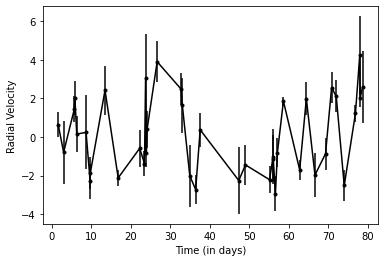

In [6]:
# Visulizing the data
plt.errorbar(time1, rv, yerr=rve, fmt='k.-')
plt.xlabel('Time (in days)')
plt.ylabel('Radial Velocity')

In [7]:
# Least-square estimate of mass from the data
# Borrowing M, MT and V1 from Point estimate section
FF = MT.dot(V1).dot(M)
cov = np.linalg.inv(FF)
theta_theoretical = cov.dot(MT).dot(V1).dot(rv)

AA_the = np.random.normal(theta_theoretical[0], cov[0][0], 10000)
BB_the = np.random.normal(theta_theoretical[1], cov[1][1], 10000)
CC_the = np.random.normal(theta_theoretical[2], cov[1][1], 10000)

mass_the1 = mass(AA_the, BB_the)
mass_the = mass_the1/5.972e+24

print('Theoretical Analysis:')
print('---------------------')
print('Estimate of mass: ' + str(np.mean(mass_the)) + ' M_earth')
print('Standard deviation in estimate: ' + str(np.std(mass_the)) + ' M_earth')

Theoretical Analysis:
---------------------
Estimate of mass: 4.712949771645404 M_earth
Standard deviation in estimate: 0.07925016530845554 M_earth


In [8]:
# Defining model
def ftheta(theta, t1):
    f1 = theta[0]*np.cos(theta[3]*t1) + theta[1]*np.sin(theta[3]*t1) + theta[2]
    return f1

# Defining log(p(theta))
def logpt(theta, sig_the):
    aa = -(3/2)*np.log(2*np.pi)
    bb = -np.log(sig_the[0])-np.log(sig_the[1])-np.log(sig_the[2])
    cc = (-0.5*(theta[0]**2/sig_the[0]**2)) - (0.5*(theta[1]**2/sig_the[1]**2)) - (0.5*(theta[2]**2/sig_the[2]**2))
    lgthe = aa + bb + cc
    if not np.isfinite(lgthe):
        return -np.inf
    return lgthe

# Defining log(likelihood)
def loglikelihood(theta):
    global time, rv, rve
    ff = ftheta(theta, time)
    nn = ((rv-ff)**2)/rve**2
    expp = np.sum(nn)
    errr = np.sum(np.log(rve))
    ll = -0.5*len(time)*np.log(2*np.pi) - errr - 0.5*expp
    if not np.isfinite(ll):
        return -np.inf
    return ll

# Defining proposal distribution
def theta_proposal(theta, sigma_prop):
    the_prop = theta + np.random.randn(4)*sigma_prop
    return the_prop

# Defining alpha
def log_alpha(theta, sig_theta, theta_prop):
    alpha = loglikelihood(theta_prop) + logpt(theta_prop, sig_theta) \
            - loglikelihood(theta) - logpt(theta, sig_theta)
    return alpha

In [9]:
def monte_carlo(sA, sB, sC):
    N = 2000000
    
    sigA = 100
    sigB = 100
    sigC = 100
    
    A0 = np.mean(AA_the)
    B0 = np.mean(BB_the)
    C0 = np.mean(CC_the)
    nu0 = (2*np.pi)/(6.5*24*60*60)
    
    acc = 0
    
    Tobs = time[-1]
    
    sN = 2*np.pi/Tobs/10
    
    sigma2 = np.array([sigA, sigB, sigC, sN])
    
    sigma1 = np.array([sA, sB, sC, sN])
    sig_prop = sigma1
    
    the_i = np.array([A0, B0, C0, nu0])
    
    An = np.array([])
    Bn = np.array([])
    Cn = np.array([])
    Nun = np.array([])
    
    for _ in tqdm(range(N)):
        theta_prop = theta_proposal(the_i, sig_prop)
        fff = log_alpha(the_i, sigma2, theta_prop)
        logalpha = np.minimum(0, fff)
        u1 = np.log(np.random.random())
        if u1 <= logalpha:
            the_i = theta_prop
            acc = acc + 1
            An = np.hstack((An, the_i[0]))
            Bn = np.hstack((Bn, the_i[1]))
            Cn = np.hstack((Cn, the_i[2]))
            Nun = np.hstack((Nun, the_i[3]))
        else:
            the_i = the_i
            
    rate = acc/N
    print('Acceptance rate is ', rate)
    return An, Bn, Cn, Nun

In [10]:
A11, B11, C11, Nu11 = monte_carlo(0.1, 0.1, 0.1)

100%|██████████| 2000000/2000000 [14:37<00:00, 2279.13it/s]

Acceptance rate is  0.194155


Empirical Measurements:
-----------------------
Estimate: 4.665964546411657 M_earth
Bias: 0.665964546411657 M_earth
Variance: 0.10758329528293188 M_earth^2
Standard Deviation: 0.3279989257344174 M_earth


Text(0, 0.5, 'Counts')

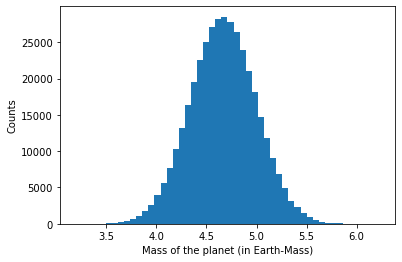

In [11]:
mass_mcmc = mass(A11,B11)
mass_mcmc1 = mass_mcmc/5.972e+24
bias2 = np.mean(mass_mcmc1)-4
vari2 = np.var(mass_mcmc1)
stdd2 = np.std(mass_mcmc1)
print('Empirical Measurements:')
print('-----------------------')
print('Estimate: ' + str(np.mean(mass_mcmc1)) + ' M_earth')
print('Bias: ' + str(bias2) + ' M_earth')
print('Variance: ' + str(vari2) + ' M_earth^2')
print('Standard Deviation: ' + str(stdd2) + ' M_earth')
#print(np.mean(m_pesti), np.std(m_pesti))
plt.hist(mass_mcmc1, bins=50)
plt.xlabel('Mass of the planet (in Earth-Mass)')
plt.ylabel('Counts')

III.4) Plot the posterior distributions of $A,B,C$ and $\nu$.
Compute the posterior mean and posterior median of $A,B,C$ and $\nu$.

Empirical Analysis of A:
------------------------
Posterior mean:  2.028998432100626
Posterior median:  2.0378433541792775


Text(0.5, 1.0, 'Posterior distribution of A')

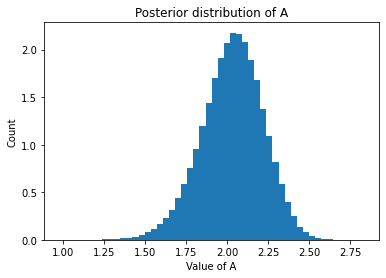

In [12]:
print('Empirical Analysis of A:')
print('------------------------')
print('Posterior mean: ', str(np.mean(A11)))
print('Posterior median: ', str(np.median(A11)))
plt.hist(A11, bins=50, density=True)
plt.xlabel('Value of A')
plt.ylabel('Count')
plt.title('Posterior distribution of A')

Empirical Analysis of B:
------------------------
Posterior mean:  0.5153101540879177
Posterior median:  0.5277655704513757


Text(0.5, 1.0, 'Posterior distribution of B')

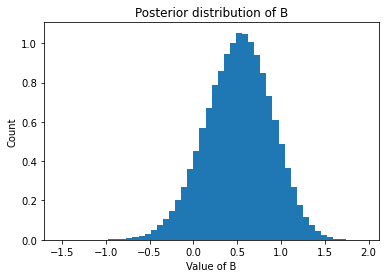

In [13]:
print('Empirical Analysis of B:')
print('------------------------')
print('Posterior mean: ', str(np.mean(B11)))
print('Posterior median: ', str(np.median(B11)))
plt.hist(B11, bins=50, density=True)
plt.xlabel('Value of B')
plt.ylabel('Count')
plt.title('Posterior distribution of B')

Empirical Analysis of C:
------------------------
Posterior mean:  -0.05738624524646381
Posterior median:  -0.05748923375721577


Text(0.5, 1.0, 'Posterior distribution of C')

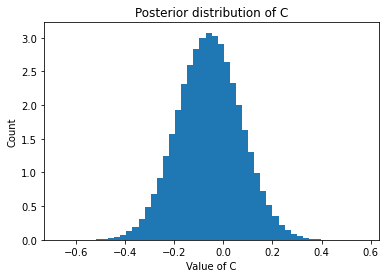

In [14]:
print('Empirical Analysis of C:')
print('------------------------')
print('Posterior mean: ', str(np.mean(C11)))
print('Posterior median: ', str(np.median(C11)))
plt.hist(C11, bins=50, density=True)
plt.xlabel('Value of C')
plt.ylabel('Count')
plt.title('Posterior distribution of C')

Empirical Analysis of Nu:
------------------------
Posterior mean:  1.1230402709616435e-05
Posterior median:  1.1230503644742198e-05


Text(0.5, 1.0, 'Posterior distribution of Nu')

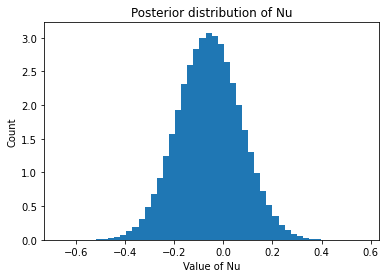

In [15]:
print('Empirical Analysis of Nu:')
print('------------------------')
print('Posterior mean: ', str(np.mean(Nu11)))
print('Posterior median: ', str(np.median(Nu11)))
plt.hist(C11, bins=50, density=True)
plt.xlabel('Value of Nu')
plt.ylabel('Count')
plt.title('Posterior distribution of Nu')

III.5) A common way to derive error bars on physical parameters is to use credible intervals. A credible interval is an interval $C$ such that a parameter 
$$\mathrm{pr}\{\theta_k \in C | y  \} = \alpha$$

Find $C_{95}$ defined as the smallest interval such that $\mathrm{Pr}\{m \in C_{95} | y  \} = 95%$


In [16]:
# Defining a function that could create a credible interval with desired confidence
def confidence_interval(array, alpha):
    aa1 = np.sort(array)
    len_chain = len(aa1)
    len_al = int(len_chain*alpha/100)
    nn = len_chain - len_al
    interval_length = np.zeros(nn)
    for i in range(nn):
        interval_length[i] = aa1[len_al + i] - aa1[i]
    arg_shortest_interval = np.argmin(interval_length)
    ll = aa1[arg_shortest_interval]
    ul = aa1[arg_shortest_interval + len_al]
    return ll, ul

In [17]:
ll1, uu1 = confidence_interval(mass_mcmc1, 95)
print('The 95% credible interval for mass is [' + str(ll1) + ', ' + str(uu1) + '] M_earth.')

The 95% credible interval for mass is [4.023111887533389, 5.306332588101473] M_earth.


III.6) Bonus question: it is not obvious whether a MCMC chain has converged. Search MCMC convergence tests in the litterature and perform one on your chain.



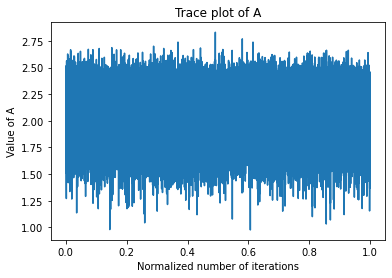

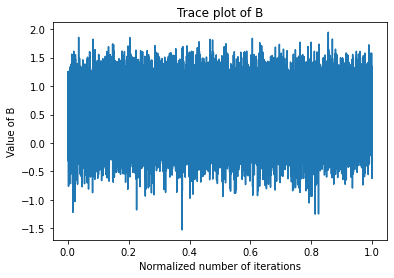

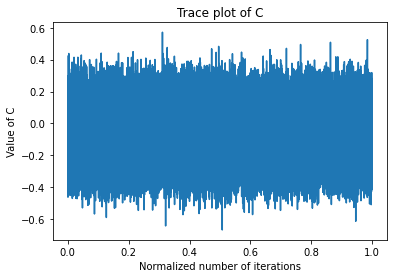

In [18]:
# The general philosophy of convergence tests is to check that 
# there are no traces of excessive correlation in the chain

# First check: trace plots. Simply plot the values taken by the chain.
xs = np.arange(1, len(A11)+1, 1)/len(A11)
plt.plot(xs, A11)
plt.xlabel('Normalized number of iterations')
plt.ylabel('Value of A')
plt.title('Trace plot of A')
plt.show()
plt.plot(xs, B11)
plt.xlabel('Normalized number of iterations')
plt.ylabel('Value of B')
plt.title('Trace plot of B')
plt.show()
plt.plot(xs, C11)
plt.xlabel('Normalized number of iterations')
plt.ylabel('Value of C')
plt.title('Trace plot of C')
plt.show()

### Gelman-Rubin Test
We try the Gelman-Rubin Test to check if the MCMC has converged or not. Below, we show a basic formulation (an algorithm) for Gelman-Rubin Test.

1. Consider mth chain: $\theta_1^m$, $\theta_2^m$, ..., $\theta_{N_m}^m$.
2. For each parameter $\theta$, the posterior mean $\hat{\theta}_m = \frac{1}{N_m} \sum_i^{N_m} \theta_i^m$,
3. For each parameter, compute the intra-chain variance, $\sigma_m^2 = \frac{1}{N_m-1}\sum_i^{N_m} \left( \theta_i^m - \hat{\theta}_m \right)^2$.
4. Compute $\hat{\theta}$, the mean of all chains, $\hat{\theta} = \frac{1}{M} \sum_m^M \hat{\theta}_m$.
5. Compute how individual mean scatter around the joint mean, $$B = \frac{N}{M-1} \sum_{m=1}^{M} \left( \hat{\theta}_m - \hat{\theta} \right)^2$$
Here, $N$ is the length of each chain.
6. Compute the averaged variance of the chains, $$W = \frac{1}{M} \sum_{m=1}^{M} \sigma_m^2$$.
7. Compute, $$\hat{V} = \frac{N-1}{N} W + \frac{M+1}{MN} B$$
8. Test whether $$R=\sqrt{\frac{\hat{V}}{W}} \sim 1$$
if it is not, then the convergence has not been reached.

Below, we try to implement this test to our chains of A, B and C

In [19]:
def gelman_rubin(ch_a, ch_b, ch_c, ch_n):
    NN = len(ch_a)
    # For a
    mean_ch_a = np.sum(ch_a)/NN
    var_ch_a = np.sum((ch_a - mean_ch_a)**2)/(NN-1)
    # For b
    mean_ch_b = np.sum(ch_b)/NN
    var_ch_b = np.sum((ch_b - mean_ch_b)**2)/(NN-1)
    # For c
    mean_ch_c = np.sum(ch_c)/NN
    var_ch_c = np.sum((ch_c - mean_ch_c)**2)/(NN-1)
    # For nu
    mean_ch_n = np.sum(ch_n)/NN
    var_ch_n = np.sum((ch_n - mean_ch_n)**2)/(NN-1)
    # Mean of means
    means = np.array([mean_ch_a, mean_ch_b, mean_ch_c, mean_ch_n])
    mean_fin = (mean_ch_a + mean_ch_b + mean_ch_c + mean_ch_n)/4
    # B
    BB = NN*np.sum((means - mean_fin)**2)/3
    # W
    WW = (1/4)*(var_ch_a + var_ch_b + var_ch_c + var_ch_n)
    # V
    VV = ((NN-1)/NN)*WW + (5/(4*NN))*BB
    RR = np.sqrt(VV/WW)
    return RR

In [20]:
R1 = gelman_rubin(A11, B11, C11, Nu11)
tol = 0.01
if np.abs(R1-1)<tol:
    print('The Chains are converged')
else:
    print('The chains are not converged')

The chains are not converged


## Using emcee to implement MCMC

In [21]:
def log_probability(th1, tt1, rr1, re1):
    # Sigmas for prior distributions
    Tobs = time[-1]
    sN = 2*np.pi/Tobs/10
    sig_the = np.array([100, 100, 100, sN])
    # Prior and Likelihood
    lpri = logpt(th1, sig_the)
    likl = loglikelihood(th1)
    if not np.isfinite(lpri):
        return -np.inf
    if not np.isfinite(likl):
        return -np.inf
    return lpri + likl

A0 = np.mean(AA_the)
B0 = np.mean(BB_the)
C0 = np.mean(CC_the)
nu0 = (2*np.pi)/(6.5*24*60*60)

nwalkers, ndim = 32, 4

posInit = np.array([A0, B0, C0, nu0]) + 1e-4 * np.random.randn(nwalkers,ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, rv, rve))
sampler.run_mcmc(posInit, 50000, progress=True)

100%|██████████| 50000/50000 [02:01<00:00, 411.09it/s]


State([[ 1.66424259e+00  7.90952319e-01  6.80338283e-02 -5.69022622e-03]
 [ 2.29799143e+00 -1.87337942e-01  1.37556790e-01 -1.12249149e-05]
 [ 1.66208077e+00  9.21189077e-01 -1.51104916e-01  1.13005241e-05]
 [ 1.81694694e+00  3.98980794e-02 -1.29272836e-01 -9.87315544e-03]
 [ 2.34612876e+00  6.22328765e-01  4.91395006e-02 -3.07582401e-03]
 [ 1.80823548e+00 -9.86187320e-02 -1.06607828e-01 -1.11404139e-05]
 [ 1.95771237e+00 -2.91442915e-02 -1.86187924e-01  1.11780497e-05]
 [ 2.25328627e+00  4.50960552e-01  1.39932619e-01  1.11925902e-05]
 [ 2.19184080e+00 -1.35427157e-01  2.99108655e-02  1.11625658e-05]
 [ 2.19211969e+00  5.81845024e-01 -2.52785441e-01  1.12263299e-05]
 [ 1.87947362e+00 -8.63701059e-01 -2.94375633e-02 -1.12735214e-05]
 [ 2.21357095e+00 -9.02617027e-02  3.61420518e-02  1.11629158e-05]
 [ 1.86005421e+00  1.06853150e+00 -2.09629187e-02 -3.07579651e-03]
 [ 2.21576240e+00 -7.71952228e-01 -1.24501827e-01 -1.12912625e-05]
 [ 2.11825186e+00  3.23381621e-01 -1.16698374e-01 -1.113

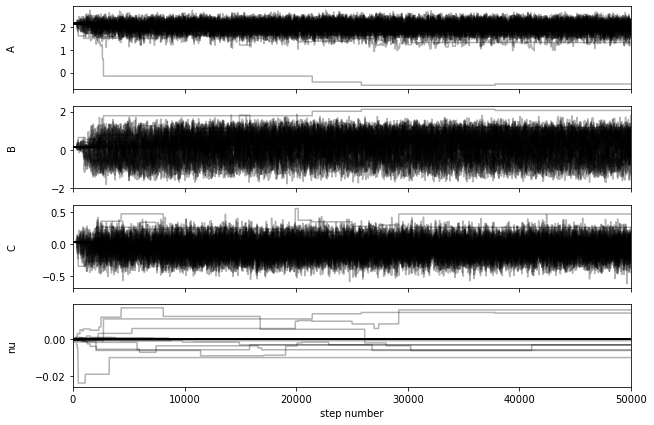

In [22]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['A', 'B', 'C', 'nu']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

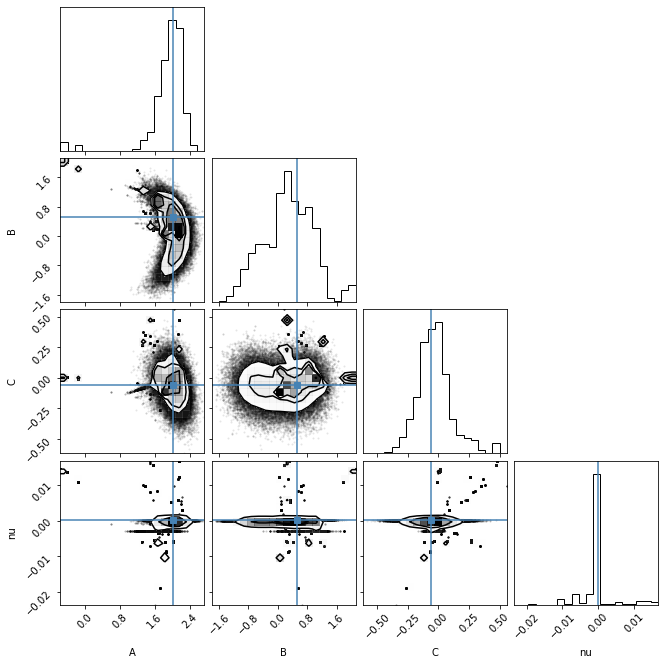

In [24]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[np.mean(A11), np.mean(B11), np.mean(C11), np.mean(Nu11)]
);

Empirical Measurements:
-----------------------
Estimate: 4.531031558257992 M_earth
Variance: 0.16640911482974174 M_earth^2
Standard Deviation: 0.4079327332168157 M_earth


Text(0, 0.5, 'Counts')

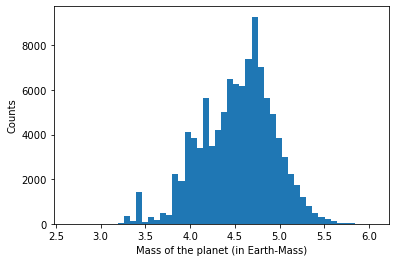

In [25]:
A_emcee = flat_samples[:,0]
B_emcee = flat_samples[:,1]

mass_emcee = mass(A_emcee, B_emcee)
mass_emcee1 = mass_emcee/5.972e+24
vari2_e = np.var(mass_emcee1)
stdd2_e = np.std(mass_emcee1)
print('Empirical Measurements:')
print('-----------------------')
print('Estimate: ' + str(np.mean(mass_emcee1)) + ' M_earth')
print('Variance: ' + str(vari2_e) + ' M_earth^2')
print('Standard Deviation: ' + str(stdd2_e) + ' M_earth')

plt.hist(mass_emcee1, bins=50)
plt.xlabel('Mass of the planet (in Earth-Mass)')
plt.ylabel('Counts')